### Historical

In [1]:
import requests
import pandas as pd
from sqlalchemy import create_engine, MetaData, delete
import numpy as np
from scipy.stats import linregress as fit

import time
import pickle
import os
from tqdm import tqdm

from datetime import timedelta, datetime
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import utils

In [2]:
thresh = 100
interval = 15

location = 'Monza'
year = 2023
needed_session = 'Race'

track_config = pd.read_csv('config/track_config.csv')
driver_config = pd.read_csv(f'config/driver_config_{year}.csv')

track = track_config.query(f''' circuit_location == '{location}' ''')

circuit_length = int(track.circuit_length.iloc[0])
corners = eval(track.corners.iloc[0])
start_line = eval(track.start_line.iloc[0])
before_start_line = eval(track.before_start_line.iloc[0])
after_start_line = eval(track.after_start_line.iloc[0])

In [3]:
#Session and circuit information

session = utils.get_session(location, year)
session_names = session.session_name[:2].tolist() #gave up on getting exactly fp1 & fp2 for knn, just getting the first two sessions of the weekend now
print(session_names)

session_key_fp1 = session.query(f'''session_name == '{session_names[0]}' ''').session_key.iloc[0]
session_key_fp2 = session.query(f'''session_name == '{session_names[1]}' ''').session_key.iloc[0]

session_key_race = session.query(f" session_name == '{needed_session}'").session_key.iloc[0]
race_start_time = pd.to_datetime(session.query(f" session_name == '{needed_session}'").date_start.iloc[0])
race_end_time = pd.to_datetime(session.query(f" session_name == '{needed_session}'").date_end.iloc[0])

driver_config = {row['name_acronym']:row['driver_number'] for ind, row in utils.get_data(f'https://api.openf1.org/v1/drivers?session_key={session_key_race}').iterrows()}
driver_config_reverse = {v: k for k, v in driver_config.items()}


['Practice 1', 'Practice 2']


In [8]:
pkl_filename = f"knn/knn_{location}-{year}_FP1_FP2_top25.pkl"
utils.save_knn_pickle(pkl_filename, session_key_fp1, session_key_fp2, start_line, before_start_line, after_start_line, LAP_THRESHOLDS = 25)

with open(pkl_filename, 'rb') as file:
    knn, start_line, before_start_line, after_start_line = pickle.load(file)

starting_grid = utils.get_starting_grid(session_key_race, race_start_time) 

knn/knn_Monza-2023_FP1_FP2_top25.pkl already exists
Done


In [9]:
# Connect to your SQL database
db_file = f"data/{session_key_race}.db"
if os.path.isfile(db_file):
    os.remove(db_file)
    print(f"Removing older DB file {db_file}")
print(f"Connecting to db using {db_file}")
engine = create_engine(f"sqlite:///{db_file}")

Removing older DB file data/9157.db
Connecting to db using data/9157.db


In [17]:
data = {}
data['data'] = {}
data['lap_number'] = {}
for driver_code, driver_number in driver_config.items():
  data['data'][driver_number] = pd.DataFrame()
  data['lap_number'][driver_code] = [1, 0]

In [18]:
# for timestamp in pd.date_range(race_start_time, race_end_time, freq = f'{interval}s'):
for timestamp in pd.date_range(race_start_time + timedelta(minutes = 1), race_end_time, freq = f'{interval}s'):

    # st = ses_start_time + timedelta(seconds=30)
    
    # while True:
    #   et = st + timedelta(seconds = interval)
    #   print(st,et)
    #   if et>ses_end_time:
    #     break

    t1 = time.time()
    st = timestamp
    et = st + timedelta(seconds = interval)
    
    weather_data = utils.get_weather_data(session_key_race, st, et)
    laptimes_data = utils.get_laptimes_data(session_key_race, st, et)
    position_data = utils.get_position_data(session_key_race, et)
    if len(weather_data):
        weather_data.map(str).to_sql('weather', engine, if_exists = 'append', index = False)
    if len(laptimes_data):
        laptimes_data.map(str).to_sql('laptimes', engine, if_exists = 'append', index = False)
    if len(position_data):
        position_data.map(str).to_sql('position', engine, if_exists = 'replace', index = False)
    
    car_data, location_data = utils.get_data_channels({'start_time' : st, 'end_time' : et, 'session_key' : session_key_race})
    telemetry_data = pd.DataFrame()
    
    for driver_code, driver_number in driver_config.items():
        try:
            merged_data = utils.merge_data_channels(car_data[car_data["driver_number"]==driver_number].sort_values(by="date"), location_data[location_data["driver_number"]==driver_number].sort_values(by="date"))
            merged_data['distance_l2'] = merged_data.apply(lambda row: utils.compute_l2((row.x, row.y), start_line, before_start_line, after_start_line), axis = 1)/10
            merged_data['distance_regr'] = knn.predict(np.asarray(merged_data[['x', 'y']]))
            merged_data['actual_distance'] = merged_data.apply(lambda row: utils.get_best_distance(row.distance_l2, row.distance_regr, thresh, circuit_length), axis = 1)
            merged_data.reset_index(inplace=True, drop=True)
            
            continuity_counter = 0
            for ind in merged_data.index[1:]:
                if merged_data.loc[ind, 'actual_distance'] - merged_data.loc[ind - (continuity_counter+1), 'actual_distance'] > 2000:
                  merged_data.drop([ind], inplace=True)
                  print(f'Deleted datapoints in {driver_code}s Lap{data["lap_number"][driver_code]}')
                  continuity_counter += 1
                else:
                  continuity_counter = 0
            
            merged_data.reset_index(inplace=True,drop=True)
            merged_data['lap_number'] = utils.assign_lap_number(merged_data, data['lap_number'][driver_code][0], circuit_length, data['lap_number'][driver_code][1])
            telemetry_data = pd.concat([telemetry_data, merged_data])
            data['lap_number'][driver_code][0] = merged_data.iloc[-1].lap_number
            data['lap_number'][driver_code][1] = merged_data.iloc[-1].actual_distance
        except Exception as e:
            print(f'{driver_number} failed')
            print(f'{e} exception')

    telemetry_data.to_sql('telemetry', engine, if_exists = 'append', index = False)
    print(et, time.time() - t1, sorted(data['lap_number'].items(), key = lambda kv: starting_grid[driver_config[kv[0]]]))
    time.sleep(10)
    # st = max(pd.to_datetime(car_data["date"].iloc[-1]), pd.to_datetime(location_data["date"].iloc[-1]))

2024-03-24 04:01:15 4.477993011474609 [('VER', [1, 3680.911527302467]), ('SAI', [1, 3581.4743219083557]), ('NOR', [1, 3476.8780928104707]), ('LEC', [1, 3304.698556851116]), ('PIA', [1, 3197.7398205179907]), ('PER', [1, 3080.8520066181604]), ('RUS', [1, 2945.819157904683]), ('TSU', [1, 2746.8780559038864]), ('STR', [1, 2588.052712480369]), ('ALO', [1, 2161.72358068687]), ('HAM', [1, 2010.7368771369272]), ('ALB', [1, 1829.9528287253504]), ('BOT', [1, 1753.517501837944]), ('MAG', [1, 1544.0611557774407]), ('OCO', [1, 1391.128303018902]), ('HUL', [1, 1287.1012821285237]), ('GAS', [1, 1242.3694739204946]), ('RIC', [1, 1201.6320760917451]), ('ZHO', [1, 5036.425979830506])]
2024-03-24 04:01:30 5.399791240692139 [('VER', [1, 4224.9104568776875]), ('SAI', [1, 4162.19370070153]), ('NOR', [1, 4120.971405897584]), ('LEC', [1, 4079.6286351990693]), ('PIA', [1, 4012.821936895524]), ('PER', [1, 3970.0946218243494]), ('RUS', [1, 3827.8472187937905]), ('TSU', [1, 3755.931551617061]), ('STR', [1, 3551.9

KeyError: 'date'

### Test laptime delta

In [76]:
import requests
import pandas as pd
from sqlalchemy import create_engine, MetaData, delete
import numpy as np
from scipy.stats import linregress as fit

import time
import pickle
import os
from tqdm import tqdm

from datetime import timedelta, datetime
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import utils

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, uniform_filter

In [55]:
engine = create_engine(f"sqlite:///data/9133.db")
circuit_length = 4381
corners = [626.695, 815.953, 1124.193, 1314.769, 1783.676, 2026.637, 2366.409, 2405.443, 2579.713, 2713.083, 2914.985, 3105.559, 3502.515, 3632.095, 3762.388, 4056.929]

In [56]:
def delta_time(ref, comp):

    ref['actual_distance_smoothed'] = gaussian_filter1d(ref.actual_distance, sigma = 10)
    comp['actual_distance_smoothed'] = gaussian_filter1d(comp.actual_distance, sigma = 10)

    ltime = comp['time'].dt.total_seconds().to_numpy()
    ldistance = comp['actual_distance_smoothed'].to_numpy()
    lap_time = np.interp(ref['actual_distance_smoothed'], ldistance, ltime)

    delta = lap_time - ref['time'].dt.total_seconds()

    # return delta, ref, comp
    return delta

lap1 1
Laptimes: 84.214 2023-07-23 13:25:42.327000 2023-07-23 13:27:06.541000
Telemetry: 84.073 2023-07-23 13:25:42.397000 2023-07-23 13:27:06.470000
lap2 11
Laptimes: 84.76 2023-07-23 13:26:02.452000 2023-07-23 13:27:27.212000
Telemetry: 84.713 2023-07-23 13:26:02.517000 2023-07-23 13:27:27.230000


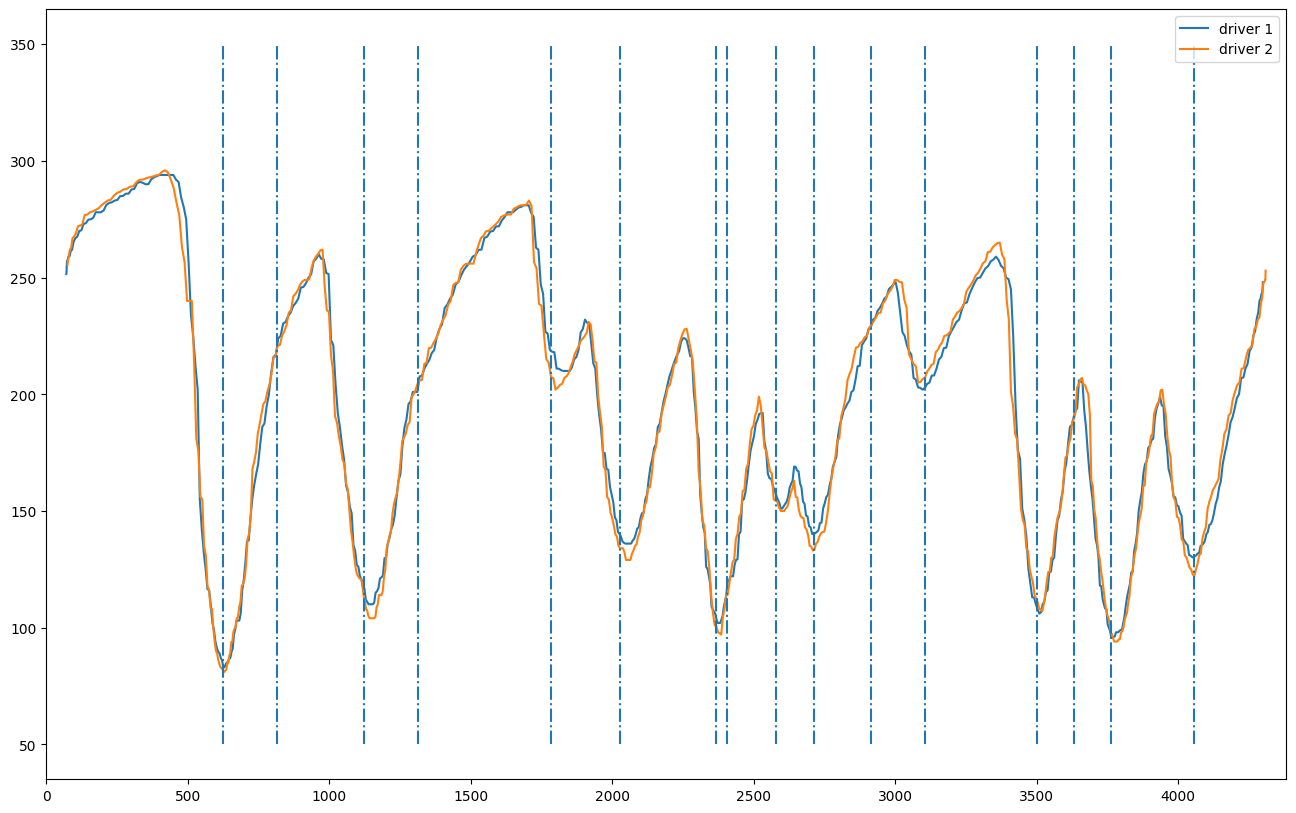

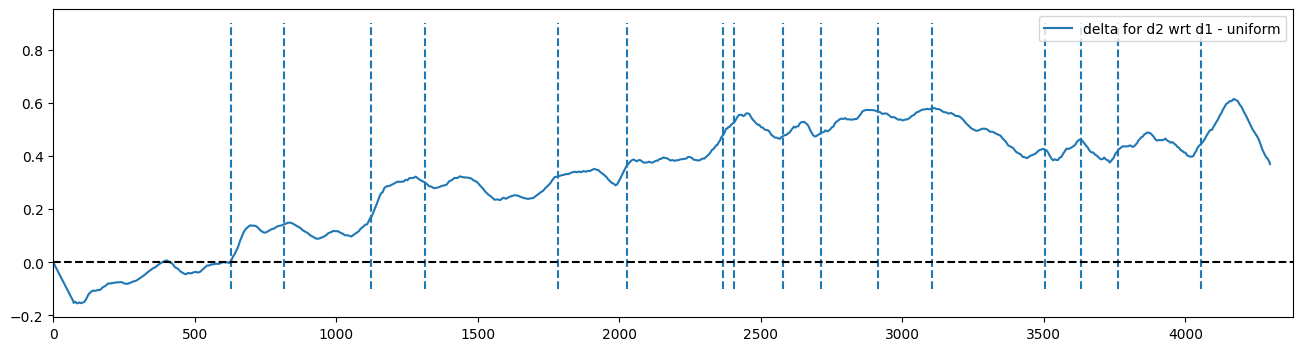

In [92]:
driver1 = 1
driver2 = 11
lap1 = 18
lap2 = 18

df1 = pd.read_sql(f'''select * from telemetry where (driver_number = {driver1}) & (lap_number = {lap1})''', engine)
df2 = pd.read_sql(f'''select * from telemetry where (driver_number = {driver2}) & (lap_number = {lap2})''', engine)
lap1 = pd.read_sql(f'''select * from laptimes where (driver_number = {driver1}) & (lap_number = {lap1-1})''', engine)
lap2 = pd.read_sql(f'''select * from laptimes where (driver_number = {driver2}) & (lap_number = {lap2-1})''', engine)

lap1_start_time = pd.to_datetime(lap1.date_start[0])
lap1_end_time = timedelta(seconds = float(lap1.lap_duration[0])) + lap1_start_time
lap2_start_time = pd.to_datetime(lap2.date_start[0])
lap2_end_time = timedelta(seconds = float(lap2.lap_duration[0])) + lap2_start_time

df1['date'] = pd.to_datetime(df1['date'], format = 'mixed') #ref
df2['date'] = pd.to_datetime(df2['date'], format = 'mixed') #comp
df1['time'] = df1['date'] - df1['date'].iloc[0]
df2['time'] = df2['date'] - df2['date'].iloc[0]

print('lap1', driver1)
print('Laptimes:', (lap1_end_time - lap1_start_time).total_seconds(), lap1_start_time, lap1_end_time)
print('Telemetry:', (df1.date.iloc[-1] - df1.date.iloc[0]).total_seconds(), df1.date.iloc[0], df1.date.iloc[-1], )
print('lap2', driver2)
print('Laptimes:', (lap2_end_time - lap2_start_time).total_seconds(), lap2_start_time, lap2_end_time)
print('Telemetry:', (df2.date.iloc[-1] - df2.date.iloc[0]).total_seconds(), df2.date.iloc[0], df2.date.iloc[-1], )

delta = delta_time(df1, df2)

# plt.plot(df1.actual_distance, delta)
plt.figure(figsize=(16,10))
plt.plot(df1.actual_distance_smoothed, df1.speed, label = 'driver 1')
plt.plot(df2.actual_distance_smoothed, df2.speed, label = 'driver 2')
plt.vlines(corners, ymin = 50, ymax = 350, linestyles = 'dashdot')
plt.xlim([0, circuit_length])
plt.legend()
plt.show()

plt.figure(figsize=(16,4))
plt.vlines(corners, ymin = -0.1, ymax = 0.9, linestyles = 'dashed')
# plt.plot([0] + df1.actual_distance_smoothed.tolist(), [0] + gaussian_filter1d(delta, sigma = 5).tolist(), label = 'delta for d2 wrt d1 - gaussian')
plt.plot([0] + df1.actual_distance_smoothed.tolist(), [0] + uniform_filter(delta, size = 30).tolist(), label = 'delta for d2 wrt d1 - uniform')
plt.hlines(0, xmin = 0, xmax = circuit_length, linestyle = 'dashed', colors = 'k')
plt.legend()
plt.xlim([0, circuit_length])
plt.show()